## ECE with increasing error percentage and decreasing success

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
import numpy as np
data = np.load('/Users/anushka/Documents/Summer-Project-/dataset/labeled_embeddings_probs_and_labels_v2.npz')
#show the keys in the file
print(data.files)
embeddings = data['test_embeddings']
print("shape of embeddings:" , embeddings.shape)
probs= data['probs']
print("shape of probs:", probs.shape)
y_labels = data['y_labels']
print("Shape of labels:", y_labels.shape)
y_true = data['y_train']
print("Shape of y_true:", y_true.shape)


['test_embeddings', 'y_train', 'y_labels', 'audio_num', 'probs', 'audio_names']
shape of embeddings: (5702, 64)
shape of probs: (5702, 12)
Shape of labels: (5702,)
Shape of y_true: (5702, 12)


In [11]:
#Predicted class
y_hat = np.argmax(probs, axis=1)
print("predicted class :", y_hat)
#Prob of predicted class
p_y_hat = np.max(probs, axis=1)
print("predicted probabilities :", p_y_hat)

#True class one hot matrix
y_star= y_true
print("true class :", y_star)
#Prob of true class
p_y_star = np.sum(probs * y_star, axis=1)
print("true class probabilities :", p_y_star)

#True class labels
y_true_class = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
print("true class labels :", y_true_class)


predicted class : [ 1 11  9 ... 11  9  1]
predicted probabilities : [0.544058   0.97347754 0.7518662  ... 0.96628433 0.9899086  0.9475812 ]
true class : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]]
true class probabilities : [0.4308202  0.97347754 0.23816009 ... 0.96628433 0.98990858 0.94758117]
true class labels : [ 8 11 11 ... 11  9  1]


In [12]:
def compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha):
    indicator = (y_true_class != y_hat).astype(float)
    numerator = p_y_star
    denominator = p_y_hat + (indicator * (p_y_star + alpha))
    tcp_star_targets = numerator / denominator
    return tcp_star_targets

tcp_star_targets = compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha=0.3)
print("tcp_star_targets shape:", tcp_star_targets)

tcp_star_targets shape: [0.33793047 1.         0.18461646 ... 1.         1.         1.        ]


In [13]:
#Computing ECE
def compute_ECE(confidences, predictions, labels, n_bins=15):
    accuracies = (predictions == labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    total_samples = len(confidences)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prop_in_bin = np.sum(in_bin) / total_samples

        if np.sum(in_bin) > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += prop_in_bin* np.abs(avg_confidence_in_bin - accuracy_in_bin)

    return ece


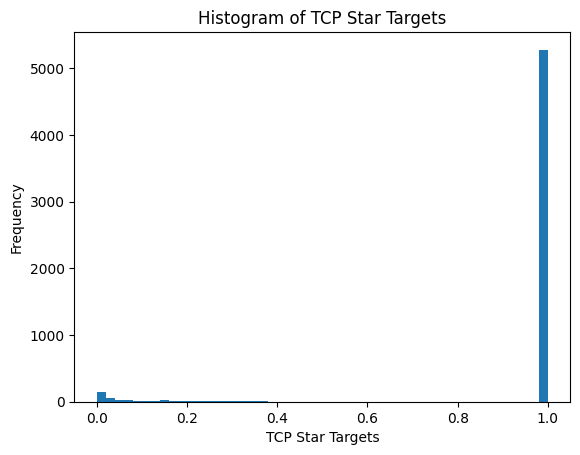

In [14]:
#plot histogram of tcp_star_targets
import matplotlib.pyplot as plt
plt.hist(tcp_star_targets, bins=50)
plt.xlabel('TCP Star Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Star Targets')
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

X= embeddings
y = tcp_star_targets
from sklearn.model_selection import train_test_split

all_indices = np.arange(len(embeddings))  
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=42)

# Now use these to split all your arrays
X_train = embeddings[train_indices]
y_train = tcp_star_targets[train_indices]

X_test = embeddings[test_indices]
y_test = tcp_star_targets[test_indices]

# Also for classifier outputs
y_hat_train = y_hat[train_indices]
y_true_class_train = y_true_class[train_indices]

In [16]:
y_hat_train.shape, y_true_class_train.shape

((4561,), (4561,))

In [17]:
is_correct = (y_hat_train == y_true_class_train)

X_errors = X_train[~is_correct]
y_errors = y_train[~is_correct]

X_success = X_train[is_correct]
y_success = y_train[is_correct]

In [18]:
model.eval()
with torch.no_grad():
    Xall_tensor = torch.tensor(embeddings, dtype=torch.float32)
    confidence_scores_tcpr = model(Xall_tensor).cpu().numpy()  # shape: (1141,)

NameError: name 'model' is not defined

In [ ]:
confidence_scores_tcpr.shape

(5702,)

In [ ]:
y_hat_test = y_hat[test_indices]  # predicted class from classifier
y_true_test = y_true_class[test_indices]  # true class label

is_correct = (y_hat_test == y_true_test)
conf_correct = test_conf[is_correct]
conf_error = test_conf[~is_correct]

y_hat_correct = y_hat_test[is_correct]
y_hat_error = y_hat_test[~is_correct]

y_true_correct = y_true_test[is_correct]
y_true_error = y_true_test[~is_correct]

In [ ]:
is_correct_train = y_hat[train_indices] == y_true_class[train_indices]

train_conf = confidence_scores_tcpr[train_indices]
train_y_hat = y_hat[train_indices]
train_y_true = y_true_class[train_indices]

conf_train_errors = train_conf[~is_correct_train]
conf_train_success = train_conf[is_correct_train]

y_hat_train_errors = train_y_hat[~is_correct_train]
y_hat_train_success = train_y_hat[is_correct_train]

y_true_train_errors = train_y_true[~is_correct_train]
y_true_train_success = train_y_true[is_correct_train]

In [ ]:
is_correct_test = y_hat[test_indices] == y_true_class[test_indices]

test_conf = confidence_scores_tcpr[test_indices]
test_y_hat = y_hat[test_indices]
test_y_true = y_true_class[test_indices]

# Only get test set errors
conf_eval_errors = test_conf[~is_correct_test]
y_hat_eval_errors = test_y_hat[~is_correct_test]
y_true_eval_errors = test_y_true[~is_correct_test]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

error_counts = []
ece_values = []

# Start config: 200 errors + 4500 successes from training set
max_steps = min(len(conf_eval_errors), 150)  # control based on available eval errors
step = 10

for i in range(0, max_steps + 1, step):
    num_added_errors = i
    num_removed_successes = i

    # Select base set
    train_errors = np.arange(200)  # first 200 errors from training
    train_success = np.arange(len(conf_train_success))
    sample_size = min(4500 - num_removed_successes, len(train_success))
    selected_successes = np.random.choice(train_success, size=sample_size, replace=False)

    # Add i errors from evaluation set
    eval_errors = np.arange(num_added_errors)

    # Final confidence
    conf_subset = np.concatenate([
        conf_train_errors[train_errors],
        conf_train_success[selected_successes],
        conf_eval_errors[eval_errors]
    ])

    y_hat_subset = np.concatenate([
        y_hat_train_errors[train_errors],
        y_hat_train_success[selected_successes],
        y_hat_eval_errors[eval_errors]
    ])

    y_true_subset = np.concatenate([
        y_true_train_errors[train_errors],
        y_true_train_success[selected_successes],
        y_true_eval_errors[eval_errors]
    ])

    # Shuffle
    idx = np.random.permutation(len(conf_subset))
    conf_subset = conf_subset[idx]
    y_hat_subset = y_hat_subset[idx]
    y_true_subset = y_true_subset[idx]

    # Compute ECE
    ece = compute_ECE(conf_subset, y_hat_subset, y_true_subset)
    ece_values.append(ece)
    error_counts.append(200 + i)

    print(f"Errors: {200+i} | Successes: {4500-i} | ECE: {ece:.4f}")

Errors: 200 | Successes: 4500 | ECE: 0.0070
Errors: 210 | Successes: 4490 | ECE: 0.0078
Errors: 220 | Successes: 4480 | ECE: 0.0091
Errors: 230 | Successes: 4470 | ECE: 0.0104
Errors: 240 | Successes: 4460 | ECE: 0.0122
Errors: 250 | Successes: 4450 | ECE: 0.0139
Errors: 260 | Successes: 4440 | ECE: 0.0160
Errors: 270 | Successes: 4430 | ECE: 0.0175
Errors: 280 | Successes: 4420 | ECE: 0.0191


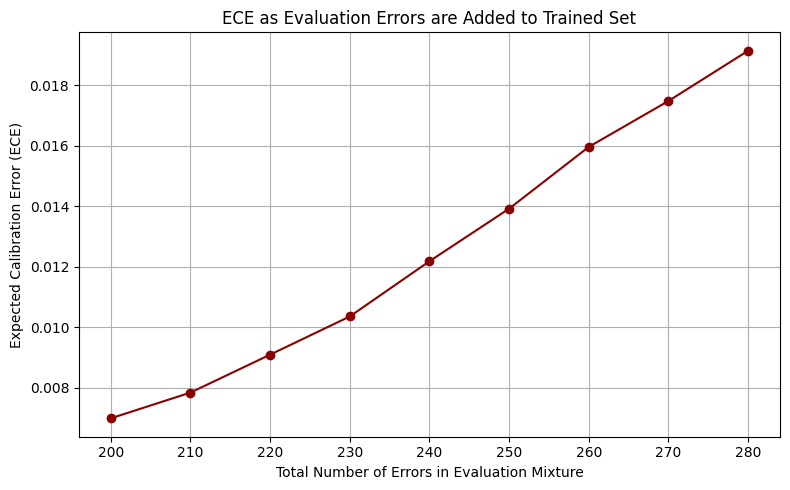

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(error_counts, ece_values, marker='o', color='darkred')
plt.xlabel('Total Number of Errors in Evaluation Mixture')
plt.ylabel('Expected Calibration Error (ECE)')
plt.title('ECE as Evaluation Errors are Added to Trained Set')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def plot_reliability_diagram(confidences, predictions, labels, n_bins=15):
    accuracies = (predictions == labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_centers = (bin_lowers + bin_uppers) / 2

    acc_bin = []
    conf_bin = []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        if np.sum(in_bin) > 0:
            acc_bin.append(np.mean(accuracies[in_bin]))
            conf_bin.append(np.mean(confidences[in_bin]))
        else:
            acc_bin.append(np.nan)
            conf_bin.append(np.nan)

    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.plot(conf_bin, acc_bin, marker='o', label='Model')
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Reliability Diagram")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

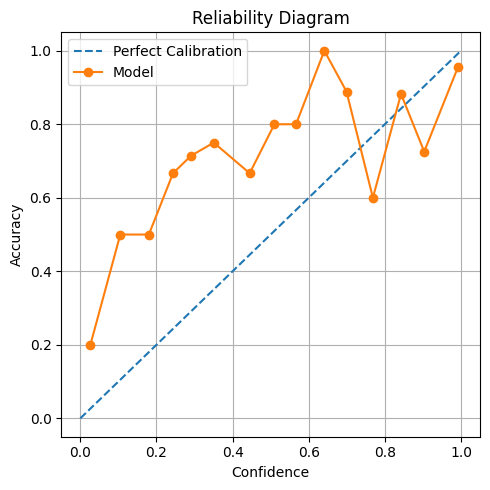

In [ ]:
# Plot reliability diagram for the validation set
plot_reliability_diagram(test_conf, test_y_hat, test_y_true)

In [ ]:

# Reliability Diagram
def plot_reliability_diagram(confidences, predictions, labels, n_bins=15):
    accuracies = (predictions == labels)
    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_centers = (bin_lowers + bin_uppers) / 2

    acc_bin = []
    conf_bin = []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        if np.sum(in_bin) > 0:
            acc_bin.append(np.mean(accuracies[in_bin]))
            conf_bin.append(np.mean(confidences[in_bin]))
        else:
            acc_bin.append(np.nan)
            conf_bin.append(np.nan)

    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.plot(conf_bin, acc_bin, marker='o', label='Model')
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Reliability Diagram")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function (example)
plot_reliability_diagram(confidence_scores_tcpr, y_hat, y_true_class)


In [ ]:

# Confidence Histogram: Correct vs Incorrect
def plot_confidence_histogram(confidences, predictions, labels):
    correct_conf = confidences[predictions == labels]
    incorrect_conf = confidences[predictions != labels]

    plt.figure(figsize=(8, 4))
    plt.hist(correct_conf, bins=20, alpha=0.6, label='Correct', color='green')
    plt.hist(incorrect_conf, bins=20, alpha=0.6, label='Incorrect', color='red')
    plt.xlabel('Predicted Confidence')
    plt.ylabel('Number of Samples')
    plt.title('Confidence Distribution: Correct vs Incorrect')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function (example)
plot_confidence_histogram(confidence_scores_tcpr, y_hat, y_true_class)
